In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import datasets

In [2]:
# virus tracker data (broken)
# m = pd.read_csv('data/virus_tracker_mapping.txt', sep='\t',
#                 names=['country', 'countrycode', '_'], usecols=['country', 'countrycode'])
# m['country'] = m['country'].str[3:]
# m['countrycode'] = m['countrycode'].str[:2]
# m.rename(columns=str.title, inplace=True)
# m.set_index('Countrycode', inplace=True)

# df = pd.DataFrame(data['data'])
# countrycodes = set(df['countrycode'])
# df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
# df.rename(columns=str.title)
# df.sort_values(['countrycode', 'date'], inplace=True)
# df.rename(columns=str.title, inplace=True)
# df.set_index(['Countrycode', 'Date'] , inplace=True)
# df = df.applymap(int)

In [4]:
df, countries = datasets.jhu()

In [5]:
colors = ['tab:orange', 'tab:red', 'tab:green']

def draw_timeline(data, country):
    fig, ax = plt.subplots(figsize=(9, 6))
    c, d, r = data.last('1D').iloc[0]
    for (label, content), color, i in zip(data.iteritems(), colors, [0, 0, 5 if (d-r)/(r+1e-10) <= 0.15 else -5]):
        ax.plot(content, label=label, color=color)
        ax.annotate(content[-1], xy=(ax.get_xticks()[-1], content[-1]),
                    xycoords=ax.transData, xytext=(20, i), textcoords='offset points',
                    va='center', ha='left', fontsize=8)
    ax.set_title(f'{country}')
    ax.get_xaxis().set_major_formatter(mpl.dates.DateFormatter('%m-%d'))
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend()
    plt.savefig(f'./country_timeline/{country.replace(" ", "-")}.png')

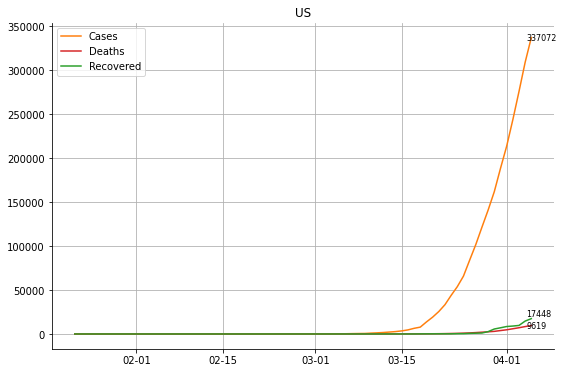

In [10]:
c = 'US'
draw_timeline(df.loc[c], c)

In [7]:
for country in countries:
    draw_timeline(df.loc[country], country)
    plt.close()

In [8]:
# generate text from markdown
# import os
# _ = 'A'
# print(f'### {_}')
# for file in [file for file in sorted(os.listdir('country_timeline')) if file.endswith('png')][1:]:
#     if file[0] > _:
#         _ = file[0]
#         print(f'### {_}')
#     print(f'![](country_timeline/{file})')